In [ ]:
!git clone https://github.com/Cornell-RelaxML/Hyperdimensional-Computing

Cloning into 'Hyperdimensional-Computing'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (30/30), 48.17 MiB | 20.81 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# for data import
from sklearn.datasets import fetch_openml, make_moons
from sklearn.model_selection import train_test_split

# introduction to PIL library for loading png images
from PIL import Image

# for random forests
from sklearn import tree

# for deep features extraction
from torchvision.models  import resnet18, ResNet18_Weights
from torchvision.models  import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision
# for transforming data in order to feed the deep feature extractor
import torch
from torch.utils.data import Dataset, DataLoader

# for performing the distance in the feature representation space
from sklearn.metrics.pairwise import cosine_distances
from torchvision import transforms
import torch.nn.functional as F
import time
import scipy
from tqdm import tqdm

In [ ]:
torch.cuda.empty_cache()

In [ ]:
X, y = fetch_openml('mnist_784', as_frame=False, return_X_y=True, parser="pandas")

In [ ]:
X.shape, X.min(), X.max()

((70000, 784), 0, 255)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[:10000], y[:10000], test_size=0.3)

In [ ]:
X_train.shape

(7000, 784)

In [ ]:
# @title
class HDDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        im = self.X[idx]
        im = im.reshape((28,28))
        im = np.tile(im[None, :, :], (3, 1, 1))
        im = torch.Tensor(im)
        label = self.y[idx]
        return im, label

In [ ]:
def data_to_tensor(X, y):
  X = torch.from_numpy(X)
  y = y.astype(float)
  y = torch.from_numpy(y)
  return X, y

In [ ]:
X_train, y_train = data_to_tensor(X_train, y_train)
X_test, y_test = data_to_tensor(X_test, y_test)

## **Linear Encoder + RFF + VSA**

In [ ]:
class LinearEncoder:
    def __init__(self, dim=10000, num=256):
        self.dim = dim
        self.num = num

    def compute_basis_hypervectors(self):
        basis_hypervectors = np.random.choice([-1, 1], size=(self.num, self.dim))
        basis_hypervectors = torch.from_numpy(basis_hypervectors)
        return basis_hypervectors

    def encode_pixel(self, pixel_intensity, basis_hypervectors, i):
        pixel_hypervector = basis_hypervectors[pixel_intensity]
        shifted_hypervector = torch.roll(pixel_hypervector, i, dims=0)
        return shifted_hypervector

    def encode_image(self, image, basis_hypervectors):
        pixel_hypervectors = torch.stack([self.encode_pixel(pixel_intensity, basis_hypervectors, i) for i, pixel_intensity in enumerate(image)])
        image_hypervector = torch.prod(pixel_hypervectors, dim=0)
        return image_hypervector

    def encode_training_dataset(self, X_train):
        encoded_hypervectors = []
        basis_hypervectors = self.compute_basis_hypervectors()
        for i in range(X_train.shape[0]):
            image = X_train[i]
            encoded_hypervector = self.encode_image(image, basis_hypervectors)
            encoded_hypervectors.append(encoded_hypervector)
            if (i % 1000 == 999): print("{} images encoded".format(i + 1))
        encoded_hypervectors = torch.stack(encoded_hypervectors)
        print('finish encoding data here')
        return encoded_hypervectors

In [ ]:
encoder = LinearEncoder()

In [ ]:
print("Encoding training data...")
train_hd = encoder.encode_training_dataset(X_train)

Encoding training data...
finish encoding data here


In [ ]:
# # @title
torch.save(train_hd, 'train_hd.pt')
torch.save(y_train, 'y_train.pt')
del train_hd, y_train
torch.cuda.empty_cache()

In [ ]:
# @title
print("Encoding test data...")
test_hd = encoder.encode_training_dataset(X_test)
# torch.save(test_hd, 'test_hd.pt')
# torch.save(y_test, 'y_test.pt')
# del test_hd, y_test
# torch.cuda.empty_cache()

Encoding test data...
finish encoding data here


In [ ]:
def load():
  print("Loading encoded training data...")
  train_hd = torch.load('train_hd.pt')
  y_train = torch.load('y_train.pt')

  print("Loading encoded test data...")
  test_hd = torch.load('test_hd.pt')
  y_test = torch.load('y_test.pt')

  print(f"Size of encoded training data {train_hd.size()} and test data {test_hd.size()}")
  return train_hd, y_train, test_hd, y_test

In [ ]:
train_hd, y_train, test_hd, y_test = load()

Loading encoded training data...
Loading encoded test data...
Size of encoded training data torch.Size([7000, 10000]) and test data torch.Size([3000, 10000])


In [ ]:
def bundling(X_train, y_train):
    num_classes = len(torch.unique(y_train))
    hypervector_length = X_train.shape[1]

    class_representatives = torch.zeros((num_classes, hypervector_length),)

    for class_label in range(num_classes):
        class_hypervectors = X_train[y_train == class_label]


        class_representative = torch.zeros(hypervector_length)
        for i in range(hypervector_length):

            ones_count = (class_hypervectors[:, i] == 1).sum()
            minus_ones_count = (class_hypervectors[:, i] == -1).sum()

            if ones_count > minus_ones_count:
                majority_value = 1
            elif ones_count < minus_ones_count:
                majority_value = -1
            else:
                majority_value = torch.randint(-1, 2, (1,))

            class_representative[i] = majority_value

        class_representatives[class_label] = class_representative

    return class_representatives

In [ ]:
class_representatives = bundling(train_hd, y_train)

In [ ]:
class_representatives.shape

torch.Size([10, 10000])

In [ ]:
torch.save(class_representatives, 'class_representatives.pt')

In [ ]:
test_hd.dtype

torch.int64

In [ ]:
def predict(test_set, class_representatives):
    num_classes = len(class_representatives)
    hypervector_length = test_set.shape[1]

    similarity_scores = torch.mm(test_set.to(dtype=torch.float32), class_representatives.t())

    predicted_classes = torch.argmax(similarity_scores, dim=1)

    return predicted_classes

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predicted_classes = predict(test_hd.to(device), class_representatives.to(device))

In [ ]:
def accuracy(test_labels, predicted_classes):
    correct_predictions = ((test_labels == predicted_classes).float())

    accuracy_score = torch.mean(correct_predictions)

    return accuracy_score

In [ ]:
acc = accuracy(y_test.to(device), predicted_classes)
print(f'The accuracy of HDC classic: {acc:.2f}')

The accuracy of HDC classic: 0.10


In [ ]:
predicted_classes

tensor([8, 8, 5,  ..., 0, 9, 5], device='cuda:0')

In [ ]:
class RandomFourierEncoder:
    def __init__(self, input_dim, gamma, gorder=2, output_dim=10000):
        self.input_dim = input_dim
        self.output_dim = output_dim
        # kernel parameter
        self.gamma = gamma
        self.gorder = gorder
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def pts_map(self, x, r=1.0):
        theta = 2.0 * np.pi / (1.0 * self.gorder) * x
        pts = r * torch.stack([torch.cos(theta), torch.sin(theta)], -1)
        return pts

    def GroupRFF(self, x, sigma):
        intervals = sigma * torch.tensor(
            [scipy.stats.norm.ppf(i * 1.0 / self.gorder) for i in range(1, self.gorder)]).float()
        print('the threshold to discretize fourier features to group elements', intervals)
        group_index = torch.zeros_like(x)
        group_index[x <= intervals[0]] = 0
        group_index[x > intervals[-1]] = self.gorder - 1
        if self.gorder > 2:
            for i in range(1, self.gorder - 1):
                group_index[(x > intervals[i - 1]) & (x <= intervals[i])] = i
        return group_index

    def build_item_mem(self):  # create random fourier features for 256 pixel values
        # a correction factor for bias
        correction_factor = 1 / 1.4
        # covariance kernel
        x = np.linspace(0, 255, num=256)
        Cov = np.array([np.exp(-correction_factor * self.gamma ** 2 * ((x - y) / 255.0) ** 2 / 2) for y in range(256)])
        k = Cov.shape[0]
        assert Cov.shape[1] == k, "Cov is not a square matrix."
        L = np.sin(Cov * np.pi / 2.0)
        ''' Eigen decomposition: L = eigen_vectors @ np.diag(eigen_values) @ eigen_vectors.T '''
        eigen_values, eigen_vectors = np.linalg.eigh(L)
        R = eigen_vectors @ np.diag(np.maximum(0, eigen_values) ** 0.5) @ eigen_vectors.T
        item_mem = torch.from_numpy(np.random.randn(self.output_dim, k) @ R).float()  # this can be reduced for effiency
        self.item_mem = self.GroupRFF(item_mem, np.sqrt((R ** 2).sum(0).max())).T  # compatible for binary HDC (with %2)
        # for binary HDC, you can also use a bipolar representation together with prod alternatively
        # self.item_mem = (((item_mem >= 0).T * 1.0 - 0.5) * 2) # bipolar representation for binary HDC
        self.item_mem = self.item_mem.to(self.device)
        return self.item_mem

    def encode_one_img(self, x):
        '''
        x:   flattened input image. size=[#pixels,]
        rfs: random feature vectors for pixel values. size=[HDC Dim, #features]
        '''
        x = x.to(self.device).long()
        bs, channels, num_pixels = x.size()
        rv = self.item_mem[x.flatten()].view(bs, channels, num_pixels, -1).transpose(0, 2)
        # rv shape now should be [num_pixels, channels, bs, hyperD]
        for i in range(num_pixels):
            # for each pixel, shift along hyperD dimension
            rv[i] = torch.roll(rv[i], shifts=783 - i,
                               dims=-1)  # note that this batch shifting might be different from our v1
        rv = torch.sum(rv, dim=0)  # use sum, natural extends to group bind, result shape: [channels, bs, hyperD]
        #         rv = torch.fmod(torch.sum(rv, dim=0), self.gorder) # mathly same since we use cos in the GModel
        if self.gorder == 2:
            rv = rv % 2
        # the following works when bipolar representation is used
        #       # rv = torch.prod(rv, 0) > 0.
        return rv.transpose(0, 1).reshape((bs, -1))

    # returns an array of HD features for multiple inputs, together with label list
    def encode_data_extract_labels(self, datast):
        '''
        datast:   trainset or testset loaded via torch. tuple style, contains N (x,y) pair.
        rfs: random feature vectors for pixel values. shape=[HDC Dim, #features]
        return: rv -> hypervectors for images. shape=[N, HDC dim]
        '''
        channels = datast[0][0].size(0)
        n = len(datast)  # number of examples in x
        rv = torch.zeros((n, channels * self.output_dim))
        labels = torch.zeros(n).long()
        print('Start encoding data')
        start_time = time.time()
        batch_size = 128
        data_loader = torch.utils.data.DataLoader(datast, batch_size=batch_size, shuffle=False)
        for i, batch_img in enumerate(data_loader):
            num_imgs = batch_img[0].size(0)  # in case the last batch is not equal to batch_size
            rv[i * batch_size: i * batch_size + num_imgs] = self.encode_one_img(
                (255 * batch_img[0].view(num_imgs, channels, -1)).int())
            labels[i * batch_size: i * batch_size + num_imgs] = batch_img[1]
            if i % 100 == 99: print(
                f"{(i + 1) * batch_size} images encoded. Total time elapse = {time.time() - start_time}")
        print('Finish encoding data')
        return rv, labels

    def group_bind(self, lst):
        results = torch.sum(lst, dim=0)
        return results  # torch.fmod(results, self.gorder) # mathematically same

    def group_bundle(self, lst):
        intervals = torch.tensor([2 * np.pi / self.gorder * i for i in range(self.gorder)]) + np.pi / self.gorder
        pts = torch.sum(self.pts_map(lst), dim=0)
        raw_angles = 2 * np.pi + torch.arctan(pts[:, 1] / pts[:, 0]) - np.pi * (pts[:, 0] < 0).float()
        angles = torch.fmod(raw_angles, 2 * np.pi)
        return torch.floor(angles / (2.0 * np.pi) * self.gorder + 1 / 2)  # torch.fmod( , self.gorder)

    def similarity(self, x, y):
        return torch.sum(torch.sum(self.pts_map(x) * self.pts_map(y), dim=-1), dim=-1) * (1.0 / x.size(-1))

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),])
trainset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)

In [ ]:
channels = trainset[0][0].size(0)
print('# of channels of data', channels)
input_dim = torch.prod(torch.tensor(list(trainset[0][0].size())))
print('# of training samples and test samples', len(trainset), len(testset))

# of channels of data 1
# of training samples and test samples 60000 10000


In [ ]:
class HDCCodingArgs:
    def __init__(self, lr=0.01, gamma=0.3, epoch=1, gorder=2, dim=10000, seed=43, resume=False, data_dir='',
                 dataset='mnist', raw_data_dir='./dataset', model='rff-hdc'):
        self.lr = lr
        self.gamma = gamma
        self.epoch = epoch
        self.gorder = gorder
        self.dim = dim
        self.seed = seed
        self.resume = resume
        self.data_dir = data_dir
        self.dataset = dataset
        self.raw_data_dir = raw_data_dir
        self.model = model

# Create an instance of the class
args = HDCCodingArgs()

In [ ]:
print("Encoding with random fourier features encoder.")
encoder = RandomFourierEncoder(input_dim=input_dim, gamma=args.gamma, gorder=args.gorder, output_dim=args.dim)

Encoding with random fourier features encoder.


In [ ]:
mem = encoder.build_item_mem()
print("Encoded pixels to hypervectors with size: ", mem.size())
torch.save(mem, f'{args.data_dir}/item_mem.pt')

print("Encoding training data...")
train_hd, y_train = encoder.encode_data_extract_labels(trainset)
torch.save(train_hd, f'{args.data_dir}/train_hd.pt')
torch.save(y_train, f'{args.data_dir}/y_train.pt')
del train_hd, y_train
torch.cuda.empty_cache()  # in case of CUDA OOM

the threshold to discretize fourier features to group elements tensor([0.])
Encoded pixels to hypervectors with size:  torch.Size([256, 10000])
Encoding training data...
Start encoding data
12800 images encoded. Total time elapse = 23.64659070968628
25600 images encoded. Total time elapse = 47.04046010971069
38400 images encoded. Total time elapse = 70.29046297073364
51200 images encoded. Total time elapse = 93.55824398994446
Finish encoding data


In [ ]:
print("Encoding test data...")
test_hd, y_test = encoder.encode_data_extract_labels(testset)
torch.save(test_hd, f'{args.data_dir}/test_hd.pt')
torch.save(y_test, f'{args.data_dir}/y_test.pt')
del test_hd, y_test
torch.cuda.empty_cache()

Encoding test data...
Start encoding data
Finish encoding data


In [ ]:
def load(args):
    #     mem = torch.load(f'{args.data_dir}/item_mem.pt')
    #     print("Loaded pixel hypervectors with size: ", mem.size())

    print("Loading encoded training data...")
    train_hd = torch.load(f'{args.data_dir}/train_hd.pt')
    y_train = torch.load(f'{args.data_dir}/y_train.pt')

    print("Loading encoded test data...")
    test_hd = torch.load(f'{args.data_dir}/test_hd.pt')
    y_test = torch.load(f'{args.data_dir}/y_test.pt')

    print(f"Size of encoded training data {train_hd.size()} and test data {test_hd.size()}")
    return train_hd, y_train, test_hd, y_test

In [ ]:
class HDDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
def prepare_data(args):
    train_hd, y_train, test_hd, y_test = load(args)
    train_dataset = HDDataset(train_hd, y_train)
    test_dataset = HDDataset(test_hd, y_test)
    trainloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=16,
                                              shuffle=True,
                                              pin_memory=True,
                                              num_workers=1)
    testloader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=16,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=1)
    return trainloader, testloader

In [ ]:
class FastSign(torch.nn.Module):
    '''
    This is a fast version of the SignActivation.
    '''

    def __init__(self):
        super(FastSign, self).__init__()

    def forward(self, input):
        out_forward = torch.sign(input)
        out_backward = torch.clamp(input, -1.3, 1.3)
        return out_forward.detach() - out_backward.detach() + out_backward


class BinaryLinear(torch.nn.Linear):
    '''
    A fully connected layer with weights binarized to {-1, +1}.
    '''

    def __init__(self, in_features, out_features, bias=True):
        super(BinaryLinear, self).__init__(
            in_features, out_features, bias
        )
        self.binarize = FastSign()

    def forward(self, input):
        return F.linear(input, self.binarize(self.weight), self.bias)


class BModel(torch.nn.Module):
    def __init__(self, in_dim=32768, classes=10):
        super(BModel, self).__init__()
        self.in_dim = in_dim
        self.fc = BinaryLinear(self.in_dim, classes, bias=False)

    def forward(self, x):
        x = self.fc(x) * (1.0 / self.in_dim ** 0.5)
        return x


class FastRound(torch.nn.Module):
    '''
    This is a fast version of the round.
    '''

    def __init__(self):
        super(FastRound, self).__init__()

    def forward(self, input):
        out_forward = torch.round(input)
        out_backward = input  # torch.clamp(input, -1.3, 1.3)
        return out_forward.detach() - out_backward.detach() + out_backward


class RoundLinear(torch.nn.Linear):
    '''
    A fully connected layer with weights rounded to closest integers
    '''

    def __init__(self, in_features, out_features, gorder, bias=True):
        super(RoundLinear, self).__init__(
            in_features, out_features, bias
        )
        self.gorder = gorder
        self.Bias = bias
        self.round = FastRound()
        self.radius = torch.nn.Parameter(torch.ones(1))  # 1.0

    def pts_map(self, x, r=1.0):
        theta = 2.0 * np.pi / (1.0 * self.gorder) * x
        pts = r * torch.stack([torch.cos(theta), torch.sin(theta)], -1)
        return pts

    def GroupSim(self, input, weight):
        map_weight = self.pts_map(weight, r=self.radius)
        map_input = self.pts_map(input).unsqueeze(1)
        return torch.sum(torch.sum(map_weight * map_input, dim=-1), dim=-1)

    def forward(self, input):
        weight_q = self.weight
        if not self.training:
            weight_q = self.round(self.weight)
        sims = self.GroupSim(input, weight_q)
        if self.Bias:
            sims += self.bias
        return sims


class GModel(torch.nn.Module):
    def __init__(self, gorder, in_dim=32768, classes=10):
        super(GModel, self).__init__()
        self.in_dim = in_dim
        self.fc = RoundLinear(self.in_dim, classes, gorder, bias=False)

    def forward(self, x):
        x = self.fc(x) * (1.0 / self.in_dim ** 0.5)
        return x

In [ ]:
def test(MODEL, loader, criterion, device, model_='rff-hdc'):
    MODEL.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            if model_ == 'rff-hdc':
                outputs = MODEL(2 * inputs - 1)
            else:
                outputs = MODEL(inputs)
            test_loss += criterion(outputs, labels)
            preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += preds.eq(labels.view_as(preds)).sum().item()
    test_loss /= len(loader.dataset)
    print('\nTesting Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))



def train(args):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # criterion = torch.nn.NLLLoss()
    criterion = torch.nn.CrossEntropyLoss()
    channels = 3 if args.dataset == 'cifar' else 1
    if args.dataset == 'isolet':
        classes = 26
    elif args.dataset == 'ucihar':
        classes = 6
    else:
        classes = 10
    if 'hdc' in args.model:
        model = BModel(in_dim=channels * args.dim, classes=classes).to(device)
    else:
        model = GModel(args.gorder, in_dim=channels * args.dim, classes=classes).to(device)

    trainloader, testloader = prepare_data(args)
    #     optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)#, momentum=0.9, weight_decay=1.0e-5)
    #     optimizer = torch.optim.Adadelta(model.parameters(), lr=args.lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    for epoch in range(args.epoch):
        print("Epoch:", epoch + 1)
        model.train()
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            if args.model == 'rff-hdc':
                outputs = model(2 * inputs - 1)
            else:
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, batch_predicted = torch.max(outputs.data, 1)
            batch_accu = 100.0 * (batch_predicted == labels).sum().item() / labels.size(0)
            if i % 50 == 49:
                print(i, "{0:.4f}".format(loss.item()), batch_accu)
        print('Start testing on test set')
        test(model, testloader, criterion, device, model_=args.model)
        print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
train(args)

## **ALBOI DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive


In [ ]:
!unzip png4.zip

In [ ]:
import glob
import os

class ALOIDataset(Dataset):
    def __init__(self, data_path='png4', view_angles=np.arange(0, 360, 5)):
        self.data_path = data_path
        self.all_folders = glob.glob(os.path.join(data_path, '*'))
        self.view_angles = view_angles
        self.transform = transforms.Compose([
            transforms.Resize(36),
            transforms.CenterCrop(32),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.all_folders)

    def __getitem__(self, idx):
        num = idx + 1
        list_path = [os.path.join(self.data_path, f'{num}/{num}_r{angle}.png') for angle in self.view_angles]
        ims = [self.transform(Image.open(im_path)) for im_path in list_path]
        return torch.stack(ims), torch.Tensor(self.view_angles), num

In [ ]:
data = ALOIDataset()

In [ ]:
data[0][0].shape

torch.Size([72, 3, 32, 32])

In [ ]:
class RandomFourierEncoder:
    def __init__(self, input_dim, gamma, gorder=2, output_dim=10000):
        self.input_dim = input_dim
        self.output_dim = output_dim
        # kernel parameter
        self.gamma = gamma
        self.gorder = gorder
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def pts_map(self, x, r=1.0):
        theta = 2.0 * np.pi / (1.0 * self.gorder) * x
        pts = r * torch.stack([torch.cos(theta), torch.sin(theta)], -1)
        return pts

    def GroupRFF(self, x, sigma):
        intervals = sigma * torch.tensor(
            [scipy.stats.norm.ppf(i * 1.0 / self.gorder) for i in range(1, self.gorder)]).float()
        print('the threshold to discretize fourier features to group elements', intervals)
        group_index = torch.zeros_like(x)
        group_index[x <= intervals[0]] = 0
        group_index[x > intervals[-1]] = self.gorder - 1
        if self.gorder > 2:
            for i in range(1, self.gorder - 1):
                group_index[(x > intervals[i - 1]) & (x <= intervals[i])] = i
        return group_index

    def build_item_mem(self):  # create random fourier features for 256 pixel values
        # a correction factor for bias
        correction_factor = 1 / 1.4
        # covariance kernel
        x = np.linspace(0, 255, num=256)
        Cov = np.array([np.exp(-correction_factor * self.gamma ** 2 * ((x - y) / 255.0) ** 2 / 2) for y in range(256)])
        k = Cov.shape[0]
        assert Cov.shape[1] == k, "Cov is not a square matrix."
        L = np.sin(Cov * np.pi / 2.0)
        ''' Eigen decomposition: L = eigen_vectors @ np.diag(eigen_values) @ eigen_vectors.T '''
        eigen_values, eigen_vectors = np.linalg.eigh(L)
        R = eigen_vectors @ np.diag(np.maximum(0, eigen_values) ** 0.5) @ eigen_vectors.T
        item_mem = torch.from_numpy(np.random.randn(self.output_dim, k) @ R).float()  # this can be reduced for effiency
        self.item_mem = self.GroupRFF(item_mem, np.sqrt((R ** 2).sum(0).max())).T  # compatible for binary HDC (with %2)
        # for binary HDC, you can also use a bipolar representation together with prod alternatively
        # self.item_mem = (((item_mem >= 0).T * 1.0 - 0.5) * 2) # bipolar representation for binary HDC
        self.item_mem = self.item_mem.to(self.device)
        return self.item_mem

    def encode_one_img(self, x):
        '''
        x:   flattened input image. size=[#pixels,]
        rfs: random feature vectors for pixel values. size=[HDC Dim, #features]
        '''
        x = x.to(self.device).long()
        bs, channels, num_pixels = x.size()
        rv = self.item_mem[x.flatten()].view(bs, channels, num_pixels, -1).transpose(0, 2)
        # rv shape now should be [num_pixels, channels, bs, hyperD]
        for i in range(num_pixels):
            # for each pixel, shift along hyperD dimension
            rv[i] = torch.roll(rv[i], shifts=1024 - i,
                               dims=-1)  # note that this batch shifting might be different from our v1
        rv = torch.sum(rv, dim=0)  # use sum, natural extends to group bind, result shape: [channels, bs, hyperD]
        #         rv = torch.fmod(torch.sum(rv, dim=0), self.gorder) # mathly same since we use cos in the GModel
        if self.gorder == 2:
            rv = rv % 2
        # the following works when bipolar representation is used
        #       # rv = torch.prod(rv, 0) > 0.
        return rv.transpose(0, 1).reshape((bs, -1))

    # returns an array of HD features for multiple inputs, together with label list
    def encode_data_extract_labels(self, datast):
        '''
        datast:   trainset or testset loaded via torch. tuple style, contains N (x,y) pair.
        rfs: random feature vectors for pixel values. shape=[HDC Dim, #features]
        return: rv -> hypervectors for images. shape=[N, HDC dim]
        '''
        channels = datast[0][0].size(0)
        n = len(datast) - 1  # number of examples in x
        rv = torch.zeros((n, channels * self.output_dim))
        labels = torch.zeros(n).long()
        print('Start encoding data')
        start_time = time.time()
        batch_size = 128
        data_loader = torch.utils.data.DataLoader(datast, batch_size=batch_size, shuffle=False)
        for i, batch_img in enumerate(data_loader):
            num_imgs = batch_img[0].size(0)  # in case the last batch is not equal to batch_size
            rv[i * batch_size: i * batch_size + num_imgs] = self.encode_one_img(
                (255 * batch_img[0].view(num_imgs, channels, -1)).int())
            labels[i * batch_size: i * batch_size + num_imgs] = batch_img[1]
            if i % 100 == 99: print(
                f"{(i + 1) * batch_size} images encoded. Total time elapse = {time.time() - start_time}")
        print('Finish encoding data')
        return rv, labels

    def group_bind(self, lst):
        results = torch.sum(lst, dim=0)
        return results  # torch.fmod(results, self.gorder) # mathematically same

    def group_bundle(self, lst):
        intervals = torch.tensor([2 * np.pi / self.gorder * i for i in range(self.gorder)]) + np.pi / self.gorder
        pts = torch.sum(self.pts_map(lst), dim=0)
        raw_angles = 2 * np.pi + torch.arctan(pts[:, 1] / pts[:, 0]) - np.pi * (pts[:, 0] < 0).float()
        angles = torch.fmod(raw_angles, 2 * np.pi)
        return torch.floor(angles / (2.0 * np.pi) * self.gorder + 1 / 2)  # torch.fmod( , self.gorder)

    def similarity(self, x, y):
        return torch.sum(torch.sum(self.pts_map(x) * self.pts_map(y), dim=-1), dim=-1) * (1.0 / x.size(-1))

In [ ]:
def prepare_data(args):
    dataloader = torch.utils.data.DataLoader(data,
                                              batch_size=1,
                                              shuffle=True,
                                              pin_memory=True,
                                              num_workers=1)
    return dataloader

In [ ]:
class HDCCodingArgs:
    def __init__(self, lr=0.01, gamma=0.3, epoch=1, gorder=8, dim=10000, seed=43, resume=False, data_dir='',
                 dataset='mnist', raw_data_dir='./dataset', model='rff-gvsa'):
        self.lr = lr
        self.gamma = gamma
        self.epoch = epoch
        self.gorder = gorder
        self.dim = dim
        self.seed = seed
        self.resume = resume
        self.data_dir = data_dir
        self.dataset = dataset
        self.raw_data_dir = raw_data_dir
        self.model = model

# Create an instance of the class
args = HDCCodingArgs()

In [ ]:
channels = data[0][0].shape[1]
print('# of channels of data', channels)
input_dim = data[0][0].shape[-1] * data[0][0].shape[-1]
print('# of input_dim ', input_dim)
print('# of training samples', len(data))

In [ ]:
print("Encoding with random fourier features encoder.")
encoder = RandomFourierEncoder(input_dim=1024, gamma=args.gamma, gorder=args.gorder, output_dim=args.dim)

mem = encoder.build_item_mem()
print("Encoded pixels to hypervectors with size: ", mem.size())
torch.save(mem, f'{args.data_dir}/item_mem.pt')

print("Encoding training data...")


Encoding with random fourier features encoder.
the threshold to discretize fourier features to group elements tensor([-1.1505, -0.6746, -0.3187,  0.0000,  0.3187,  0.6746,  1.1505])
Encoded pixels to hypervectors with size:  torch.Size([256, 10000])
Encoding training data...


In [ ]:
from tqdm import tqdm
n = len(data)
output_dim = 10000
batch_size = 72
rv = torch.zeros((n, batch_size, channels * output_dim))
print('Start encoding data')
start_time = time.time()
for i in tqdm(range(n)):
    batch_img = data[i]
    num_imgs = batch_img[0].size(0)  # in case the last batch is not equal to batch_size
    rv[i, :, :] = encoder.encode_one_img(
        (255 * batch_img[0].view(num_imgs, channels, -1)).int())
    if i % 100 == 99: print(
        f"{(i + 1) * batch_size} images encoded. Total time elapse = {time.time() - start_time}")
print('Finish encoding data')

Start encoding data


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]

7200 images encoded. Total time elapse = 70.71986627578735
Finish encoding data


In [ ]:
print("saving encoded data...")
torch.save(rv, 'data_rff.pt')

saving encoded data...


In [ ]:
def load():
  print("Loading encoded data...")
  data_rff = torch.load('data_rff.pt')

  print(f"Size of encoded data {data_rff.size()}")
  return data_rff

In [ ]:
data_rff = load()

Loading encoded data...
Size of encoded data torch.Size([100, 72, 30000])


In [ ]:
def pred(q, z, data):
  n = len(data)
  similarities = torch.zeros((n))
  Izq = data_rff[q, z, :]
  x = 0
  y = int(2*z - x)
  for k in range(n):
    Ixk = data_rff[k, x, :]
    Iyk = data_rff[k, y, :]
    bundle_xy = encoder.group_bundle(torch.stack([Ixk, Iyk]))
    similarities[k] = encoder.similarity(bundle_xy, Izq)
  pred = torch.argmax(similarities)
  return pred

In [ ]:
def accuracy(z, data):
  n = len(data)
  prediction = torch.zeros((n))
  for q in tqdm(range(n)):
    predi = pred(q, z, data)
    prediction[q] = predi
  accuracy = torch.sum(prediction == torch.arange(0,n)) / n
  return accuracy

In [ ]:
Y = np.array([accuracy(z, data_rff) for z in range(35)])

100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


In [ ]:
print("saving Accuracy ...")
torch.save(Y, 'Accuracy.pt')

saving Accuracy ...


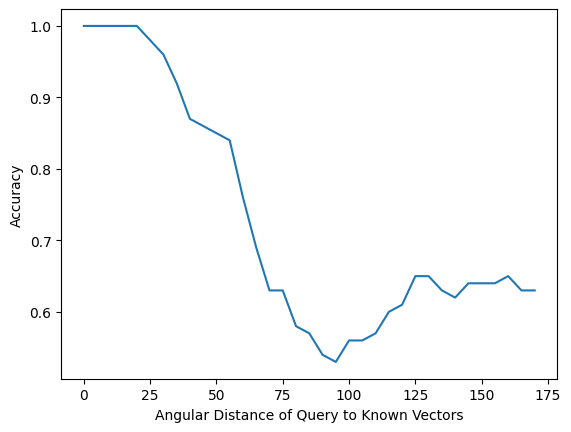

In [ ]:
Y = torch.load('Accuracy.pt')
X = np.arange(0, 175,5)
plt.plot(X, Y)

plt.xlabel('Angular Distance of Query to Known Vectors')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
def bundle(x,z,y):
  return encoder.group_bundle(torch.stack([x, z, y]))

def get_Ixk(k, x, data):
  return data_rff[k, x, :]

In [ ]:
def create_dataset(data):
  n = len(data)
  dataset = torch.empty(1)
  labels = torch.empty(1)
  for k in tqdm(range(n)):
    for z in range(35) :
      x = 0
      y = int(2*z - x)
      Ixk = get_Ixk(k, x, data)
      Izk = get_Ixk(k, z, data)
      Iyk = get_Ixk(k, y, data)
      bundle_true = bundle(Ixk, torch.roll(Izk, shifts=1024), torch.roll(Iyk, shifts=1024*2))
      bundle_false1 = bundle(Ixk, torch.roll(Iyk, shifts=1024), torch.roll(Izk, shifts=1024*2))
      bundle_false2 = bundle(Iyk, torch.roll(Ixk, shifts=1024), torch.roll(Izk, shifts=1024*2))
      bundle_false3 = bundle(Iyk, torch.roll(Izk, shifts=1024), torch.roll(Ixk, shifts=1024*2))
      bundle_false4 = bundle(Izk, torch.roll(Iyk, shifts=1024), torch.roll(Ixk, shifts=1024*2))
      bundle_false5 = bundle(Izk, torch.roll(Ixk, shifts=1024), torch.roll(Iyk, shifts=1024*2))
      dataset = torch.cat([dataset, bundle_true, bundle_false1, bundle_false2,
                             bundle_false3, bundle_false4, bundle_false5])
      labels = torch.cat([labels, torch.ones(1), torch.zeros(1), torch.zeros(1),
                          torch.zeros(1), torch.zeros(1), torch.zeros(1)])
  return dataset[1:], labels[1:]

In [ ]:
data, labels = create_dataset(data_rff)

100%|██████████| 100/100 [52:08<00:00, 31.29s/it]


In [ ]:
print("saving classifier data ...")
torch.save(data, 'classifier_data.pt')
torch.save(labels, 'classifier_labels.pt')

saving classifier data ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
data = torch.load('classifier_data.pt').data.view(21000, -1)
labels = torch.load('classifier_labels.pt')

In [ ]:
data.shape

torch.Size([21000, 30000])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the dataset and data loader
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.data)



In [ ]:
majority_indices = torch.where(labels == 0)[0]
minority_indices = torch.where(labels == 1)[0]

# Randomly undersample majority class
random_majority_indices = torch.randint(high=len(majority_indices), size=(len(minority_indices)*5,), dtype=torch.long)
undersampled_indices = torch.cat([random_majority_indices, minority_indices])

# Create the undersampled dataset
X_resampled = data[undersampled_indices]
y_resampled = labels[undersampled_indices]

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MyDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
del X_resampled, y_resampled, X_train, X_test, y_train, y_test, data, labels

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Device configuration (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=7)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=7)
        self.fc1 = nn.Linear(32 * 611, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 611)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # No sigmoid here, BCEWithLogitsLoss will handle it

# Instantiate the model, move it to the GPU if available
model = CNNModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

# Training loop
train_losses = []
test_losses = []
accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop (optional)
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            test_loss += loss.item()
            total += labels.size(0)
            correct += ((outputs > 0).int() == labels.view(-1, 1)).sum().item()

        accuracy = correct / total
        accuracies.append(accuracy)
        train_losses.append(train_loss / len(train_dataloader))
        test_losses.append(test_loss / len(test_dataloader))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataloader)}, Test Loss: {test_loss/len(test_dataloader)}, Accuracy: {accuracy}')


  5%|▌         | 1/20 [00:05<01:47,  5.67s/it]

Epoch 1/20, Train Loss: 0.6573136247156237, Test Loss: 0.5763955152396, Accuracy: 0.6978571428571428


 10%|█         | 2/20 [00:11<01:43,  5.77s/it]

Epoch 2/20, Train Loss: 0.4639194001489719, Test Loss: 0.4056080484932119, Accuracy: 0.8226190476190476


 15%|█▌        | 3/20 [00:17<01:37,  5.75s/it]

Epoch 3/20, Train Loss: 0.32111804453592335, Test Loss: 0.3603369645548589, Accuracy: 0.8469047619047619


 20%|██        | 4/20 [00:23<01:32,  5.76s/it]

Epoch 4/20, Train Loss: 0.26557327517991736, Test Loss: 0.44775357752135303, Accuracy: 0.7876190476190477


 25%|██▌       | 5/20 [00:28<01:26,  5.79s/it]

Epoch 5/20, Train Loss: 0.23193879006253448, Test Loss: 0.33114840903065423, Accuracy: 0.8671428571428571


 30%|███       | 6/20 [00:34<01:20,  5.76s/it]

Epoch 6/20, Train Loss: 0.19067808029599517, Test Loss: 0.3629063058531646, Accuracy: 0.8690476190476191


 35%|███▌      | 7/20 [00:40<01:15,  5.78s/it]

Epoch 7/20, Train Loss: 0.16140289419107565, Test Loss: 0.324318547479131, Accuracy: 0.8776190476190476


 40%|████      | 8/20 [00:46<01:09,  5.78s/it]

Epoch 8/20, Train Loss: 0.13238509561682382, Test Loss: 0.3434770249507644, Accuracy: 0.8854761904761905


 45%|████▌     | 9/20 [00:51<01:03,  5.75s/it]

Epoch 9/20, Train Loss: 0.12898939666639261, Test Loss: 0.438518966237704, Accuracy: 0.8628571428571429


 50%|█████     | 10/20 [00:57<00:57,  5.77s/it]

Epoch 10/20, Train Loss: 0.12052435429320589, Test Loss: 0.4263459766904513, Accuracy: 0.8740476190476191


 55%|█████▌    | 11/20 [01:03<00:51,  5.76s/it]

Epoch 11/20, Train Loss: 0.11040617069831479, Test Loss: 0.38006380968021625, Accuracy: 0.8811904761904762


 60%|██████    | 12/20 [01:09<00:47,  5.88s/it]

Epoch 12/20, Train Loss: 0.0947830402239194, Test Loss: 0.3652297113880967, Accuracy: 0.8840476190476191


 65%|██████▌   | 13/20 [01:15<00:41,  5.87s/it]

Epoch 13/20, Train Loss: 0.08886676312498606, Test Loss: 0.39959912035952916, Accuracy: 0.8964285714285715


 70%|███████   | 14/20 [01:21<00:34,  5.82s/it]

Epoch 14/20, Train Loss: 0.09198085108538204, Test Loss: 0.42070903425866907, Accuracy: 0.8766666666666667


 75%|███████▌  | 15/20 [01:26<00:28,  5.80s/it]

Epoch 15/20, Train Loss: 0.07805882339071865, Test Loss: 0.4089188708387541, Accuracy: 0.9073809523809524


 80%|████████  | 16/20 [01:32<00:23,  5.80s/it]

Epoch 16/20, Train Loss: 0.07872799612907516, Test Loss: 0.4699519257428068, Accuracy: 0.8885714285714286


 85%|████████▌ | 17/20 [01:38<00:17,  5.77s/it]

Epoch 17/20, Train Loss: 0.07844767778821488, Test Loss: 0.41841850170131883, Accuracy: 0.9004761904761904


 90%|█████████ | 18/20 [01:44<00:11,  5.77s/it]

Epoch 18/20, Train Loss: 0.05951259209785058, Test Loss: 0.4266077255209287, Accuracy: 0.9042857142857142


 95%|█████████▌| 19/20 [01:49<00:05,  5.77s/it]

Epoch 19/20, Train Loss: 0.07181264591994678, Test Loss: 0.5116154765992453, Accuracy: 0.8957142857142857


100%|██████████| 20/20 [01:55<00:00,  5.78s/it]

Epoch 20/20, Train Loss: 0.06264426181192011, Test Loss: 0.43927392679633515, Accuracy: 0.909047619047619


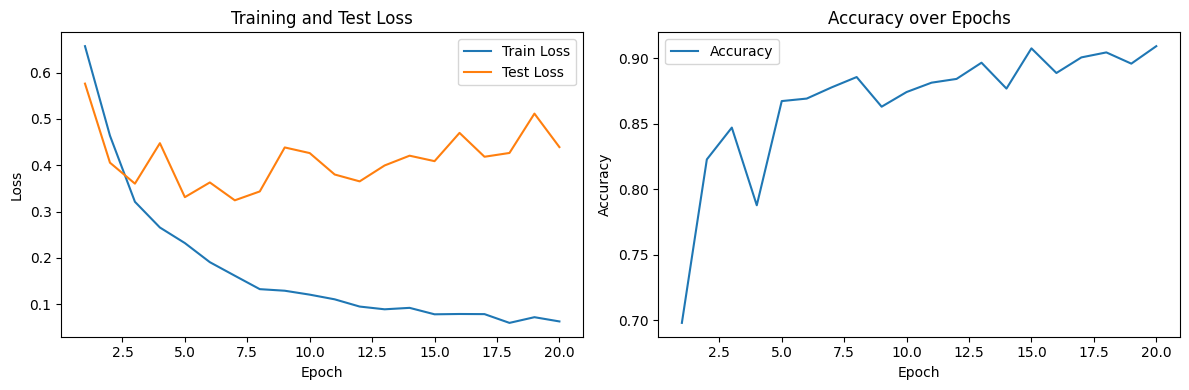

In [ ]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracies, label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()